# Transfer Learning

Closely modeled after fast.ai's [NLP course](https://github.com/fastai/course-nlp). We augment the hate speech class in the training set and perform 5-fold cross validation. Notice that you can simply use the language models if you have them, instead of training them again.

## Settings & Imports

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import os.path
import numpy as np
from utils import preprocess
from sklearn.model_selection import KFold
from fastai.text import *

## Train Language Model

In [3]:
path = "./data"
bs = 128  # Batch size

# If files have been saved, load them.
try:
    
    data_lm = load_data(path, 'augdata_lm_export.pkl', bs=bs)
    data_bwd = load_data(path, 'augdata_lm_export.pkl', bs=bs, backwards=True)
    print("Saved files loaded successfully...\n")
    
except:
    
    print("Files not found. Creating data files...\n")
    
    # Language model data
    data_lm = TextLMDataBunch.from_csv(path, 'augmented_data.csv', text_cols='tweet', bs=bs)
    
    # Save files
    data_lm.save('augdata_lm_export.pkl')
    
    # Load backwards data
    data_bwd = load_data(path, 'augdata_lm_export.pkl', bs=bs, backwards=True)

Saved files loaded successfully...



In [4]:
data_lm.show_batch()

idx,text
0,"xxup rt xxup mentionhere : idgaf what you bitches say about me 😂 xxbos xxup rt xxup mentionhere : xxmaj girls "" go talk to your other hoes "" game too strong xxbos xxup rt xxup mentionhere : xxmaj in the xxmaj yankees draft room , they had a huge picture of xxmaj greg xxmaj campbell with the message , "" this is the makeup we 're looking for ."
1,actually want to kick y' all in the ovaries . ” xxbos xxup rt xxup mentionhere : xxmaj rt if you killed a bitch with your dick xxbos xxup rt xxup mentionhere : need my dick sucked .. fuck 1 bitch i need ✌ ️ sluts xxbos xxmaj my white queen dreading her hairs . xxmaj thank you xxmaj most xxmaj high for another xxmaj moor xxmaj queen i asked
2,"standing in rear of him looking like rogue from the xmen xxbos xxup rt xxup mentionhere : xxmaj my body count had from 4 to 11 in one semester ... i 'm not a hoe really love sex xxup -famu xxbos xxmaj he be like "" bitch dontouch her braids "" xxbos xxup rt xxup mentionhere : xxmaj go dumb bitch do their dumb dance xxbos xxup rt xxup mentionhere"
3,apes of the four calling birds of the three french hens of the two turtle doves of the partridge in … xxbos xxup rt xxup mentionhere : it 's these fun and games after i have to slap a bitch xxbos xxup rt xxup mentionhere : u a hoe if you have parents and you 're n't awake xxbos xxup rt xxup mentionhere : xxmaj thanks to xxup mentionhere i
4,"cloud do ? xxbos xxmaj she do nt wanna fuck me she wanna fuck my wrist .. let her like young dro fuck dat bitch xxbos i love bad bitches that 's my fuckin problem . xxbos xxmaj you always find something to bitch about . xxbos xxmaj slack jawed yokel daughter xxup urlhere xxbos xxmaj their got ta be a loaded lux vs xxmaj murda mook 3 xxbos """


### Fine-Tuning (Forward)

In [5]:
learn_lm = language_model_learner(data_lm, AWD_LSTM, drop_mult=1).to_fp16(clip=0.1)

In [6]:
learn_lm.fit_one_cycle(1, 1e-1,  moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,4.816373,4.249444,0.274943,00:54


In [7]:
learn_lm.unfreeze()
learn_lm.fit_one_cycle(40, slice(1e-4,1e-2), moms=(0.8,0.7), wd=0.1)

epoch,train_loss,valid_loss,accuracy,time
0,4.396127,4.179754,0.279911,01:06
1,4.318073,4.113418,0.285320,01:06
2,4.222840,4.024739,0.292076,01:06
3,4.105904,3.901357,0.303065,01:06
4,3.970803,3.755224,0.317912,01:06
5,3.808260,3.594261,0.333914,01:06
6,3.623384,3.411365,0.355290,01:06
7,3.468837,3.242061,0.376396,01:06
8,3.294715,3.081893,0.398182,01:06
9,3.138016,2.931316,0.422021,01:06


In [8]:
learn_lm.save_encoder('fwd_enc')

### Fine-Tuning (Backward)

In [9]:
learn_bwd = language_model_learner(data_bwd, AWD_LSTM, drop_mult=1).to_fp16(clip=0.1)

In [10]:
learn_bwd.fit_one_cycle(1, 1e-1,  moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,4.822552,4.236195,0.302708,00:54


In [11]:
learn_bwd.unfreeze()
learn_bwd.fit_one_cycle(40, slice(1e-4,1e-2), moms=(0.8,0.7), wd=0.1)

epoch,train_loss,valid_loss,accuracy,time
0,4.404993,4.172033,0.308604,01:06
1,4.311677,4.100274,0.314916,01:06
2,4.212163,4.007856,0.322669,01:06
3,4.100806,3.885247,0.333098,01:06
4,3.947681,3.734941,0.346952,01:06
5,3.784808,3.575232,0.363177,01:06
6,3.616874,3.394658,0.383195,01:06
7,3.421961,3.212394,0.406096,01:06
8,3.255813,3.046401,0.428894,01:06
9,3.098622,2.896456,0.451684,01:06


In [12]:
learn_bwd.save_encoder('bwd_enc')

## Train Classifier

In [13]:
def augment(df, df_aug, train_index, valid_index):
    '''Auxiliary function that receives the indices of the training and validation set
       and returns the augmented forward and backward datab bunches.
       
       df and df_aug should be the non-augmented and augmented datasets, respectively.
       '''
    
    # Temporary non-aug train df
    temp_train = df.iloc[train_index]
    
    # Find hate and non-hate
    hate = temp_train.loc[temp_train["class"] == 0]
    non_hate = temp_train.loc[temp_train["class"] != 0][["tweet", "class"]]
    
    # Augment hate class
    aug_hate = df_aug.loc[df_aug["idx"].isin(hate.index), :][["tweet", "class"]]
    
    # Create augmented training set
    train_df = pd.concat([non_hate, aug_hate])
    
    # Shuffle
    train_df = train_df.iloc[np.random.permutation(len(train_df))]
    
    # Validation
    valid_df = df.iloc[valid_index]
    
    # Create Data Bunch object
    data_clas = TextClasDataBunch.from_df("./", train_df, valid_df, text_cols="tweet", label_cols="class",  
                                  vocab = data_lm.vocab, bs=bs)
    
    # Save files
    data_clas.save('class_export.pkl')
    
    # Load backwards data
    data_clas_bwd = load_data(path, 'class_export.pkl', bs=bs, backwards=True)
    
    return data_clas, data_clas_bwd

In [14]:
def train_classifiers(data_class, data_class_bwd, id="", save=True):
    
    ##### FORWARD #####
    
    if id: id = f"fold{id}_"
    
    learn_class = text_classifier_learner(data_clas, AWD_LSTM, drop_mult=0.5, pretrained=False)
    learn_class.load_encoder('fwd_enc')
    learn_class.freeze()
    
    lr = 5e-2
    learn_class.fit_one_cycle(2, lr, moms=(0.8,0.7), wd=0.1)
    
    learn_class.freeze_to(-2)
    lr /= 5
    learn_class.fit_one_cycle(1, slice(lr/(2.6**4),lr), moms=(0.8,0.7), wd=0.1)

    learn_class.freeze_to(-3)
    lr /= 2
    learn_class.fit_one_cycle(1, slice(lr/(2.6**4),lr), moms=(0.8,0.7), wd=0.1)

    learn_class.unfreeze()
    lr /= 5

    learn_class.fit_one_cycle(1, slice(lr/(2.6**4),lr), moms=(0.8,0.7), wd=0.1)
    
    if save: learn_class.save(id+'fwd_clas')
    
    ##### BACKWARD #####
    
    learn_class_bwd = text_classifier_learner(data_clas_bwd, AWD_LSTM, drop_mult=0.5, pretrained=False)
    learn_class_bwd.load_encoder('bwd_enc')
    learn_class_bwd.freeze()

    lr = 5e-2
    learn_class_bwd.fit_one_cycle(2, lr, moms=(0.8,0.7), wd=0.1)

    learn_class_bwd.freeze_to(-2)
    lr /= 5
    learn_class_bwd.fit_one_cycle(1, slice(lr/(2.6**4),lr), moms=(0.8,0.7), wd=0.1)
    learn_class_bwd.freeze_to(-3)
    lr /= 2
    learn_class_bwd.fit_one_cycle(1, slice(lr/(2.6**4),lr), moms=(0.8,0.7), wd=0.1)

    learn_class_bwd.unfreeze()
    lr /= 5
    
    learn_class_bwd.fit_one_cycle(6, slice(lr/(2.6**4),lr), moms=(0.8,0.7), wd=0.1)
        
    if save: learn_class_bwd.save(id+'bwd_clas')
    
    ##### ENSEMBLE ##### 
    
    pred_fwd, y_true = learn_class.get_preds(ordered=True)
    pred_bwd, _ = learn_class_bwd.get_preds(ordered=True)

    final_preds = (pred_fwd+pred_bwd)/2
    y_pred = final_preds.data.max(1)[1].numpy()
    
    return(y_pred, y_true, pred_fwd.data.max(1)[1].numpy())


In [15]:
# Load the data
df = pd.read_csv("preprocessed_data.csv", header="infer")
df_aug = pd.read_csv("augmented_data.csv", header="infer")

# Instantiate 5-fold CV object
kf = KFold(n_splits=5, random_state=20200126, shuffle=True)

# Storage vectors for all predictions and labels
preds, labels, preds_fwd_only = [], [], []

# For each fold 
for i, (train_index, valid_index) in enumerate(kf.split(df), 1):
    
    print(f"------------------------------------\nTRAINING FOLD : {i}\n------------------------------------")
    
    # Augment and generate data bunches
    data_clas, data_clas_bwd = augment(df, df_aug, train_index, valid_index)
    
    # Train classifier and save predictions
    y_pred, y_true, y_fwd = train_classifiers(data_clas, data_clas_bwd, id=i)
    preds.append(y_pred)
    labels.append(y_true)
    preds_fwd_only.append(y_fwd)
    
preds = np.concatenate(preds)
labels = np.concatenate(labels)
preds_fwd_only = np.concatenate(preds_fwd_only)

------------------------------------
TRAINING FOLD : 1
------------------------------------


epoch,train_loss,valid_loss,accuracy,time
0,0.698329,0.481908,0.805326,00:07
1,0.656277,0.474435,0.837805,00:07


epoch,train_loss,valid_loss,accuracy,time
0,0.578868,0.376114,0.865241,00:08


epoch,train_loss,valid_loss,accuracy,time
0,0.417556,0.310126,0.888441,00:13


epoch,train_loss,valid_loss,accuracy,time
0,0.254178,0.298834,0.893686,00:18


epoch,train_loss,valid_loss,accuracy,time
0,0.727454,0.575615,0.781521,00:07
1,0.697542,0.496507,0.825903,00:07


epoch,train_loss,valid_loss,accuracy,time
0,0.556841,0.369547,0.864031,00:09


epoch,train_loss,valid_loss,accuracy,time
0,0.428747,0.329172,0.873512,00:14


epoch,train_loss,valid_loss,accuracy,time
0,0.357739,0.336874,0.872100,00:17
1,0.323374,0.296233,0.891467,00:17
2,0.272064,0.282145,0.900343,00:16
3,0.232193,0.291495,0.899133,00:17
4,0.208572,0.288593,0.902562,00:19
5,0.204028,0.280865,0.905790,00:17


------------------------------------
TRAINING FOLD : 2
------------------------------------


epoch,train_loss,valid_loss,accuracy,time
0,0.650363,0.490807,0.815009,00:07
1,0.685302,0.482670,0.816825,00:08


epoch,train_loss,valid_loss,accuracy,time
0,0.573773,0.382147,0.853137,00:09


epoch,train_loss,valid_loss,accuracy,time
0,0.432378,0.328038,0.875530,00:14


epoch,train_loss,valid_loss,accuracy,time
0,0.316661,0.317949,0.884406,00:16


epoch,train_loss,valid_loss,accuracy,time
0,0.738743,0.547157,0.800282,00:07
1,0.662625,0.455261,0.823684,00:07


epoch,train_loss,valid_loss,accuracy,time
0,0.538748,0.341008,0.870486,00:08


epoch,train_loss,valid_loss,accuracy,time
0,0.431748,0.344567,0.869679,00:13


epoch,train_loss,valid_loss,accuracy,time
0,0.371007,0.316113,0.883599,00:18
1,0.315093,0.302881,0.887835,00:16
2,0.267523,0.304909,0.889248,00:17
3,0.243355,0.303563,0.894291,00:17
4,0.206324,0.297030,0.897115,00:16
5,0.198544,0.308120,0.897519,00:17


------------------------------------
TRAINING FOLD : 3
------------------------------------


epoch,train_loss,valid_loss,accuracy,time
0,0.670361,0.565310,0.795239,00:07
1,0.644522,0.497366,0.822877,00:07


epoch,train_loss,valid_loss,accuracy,time
0,0.515767,0.377419,0.853137,00:08


epoch,train_loss,valid_loss,accuracy,time
0,0.410223,0.335757,0.870083,00:14


epoch,train_loss,valid_loss,accuracy,time
0,0.284598,0.329721,0.882389,00:18


epoch,train_loss,valid_loss,accuracy,time
0,0.740533,0.562728,0.797458,00:07
1,0.685895,0.500044,0.818439,00:07


epoch,train_loss,valid_loss,accuracy,time
0,0.535182,0.391430,0.850514,00:08


epoch,train_loss,valid_loss,accuracy,time
0,0.430275,0.352831,0.863627,00:13


epoch,train_loss,valid_loss,accuracy,time
0,0.363233,0.347447,0.866452,00:18
1,0.309829,0.338834,0.874521,00:16
2,0.269609,0.348032,0.875328,00:17
3,0.224986,0.351154,0.876740,00:17
4,0.204298,0.333355,0.885011,00:16
5,0.192460,0.336735,0.886827,00:17


------------------------------------
TRAINING FOLD : 4
------------------------------------


epoch,train_loss,valid_loss,accuracy,time
0,0.710154,0.514837,0.801251,00:08
1,0.596234,0.452080,0.835351,00:07


epoch,train_loss,valid_loss,accuracy,time
0,0.552539,0.378809,0.865617,00:09


epoch,train_loss,valid_loss,accuracy,time
0,0.423045,0.321461,0.884988,00:13


epoch,train_loss,valid_loss,accuracy,time
0,0.330201,0.319380,0.888822,00:17


epoch,train_loss,valid_loss,accuracy,time
0,0.744091,0.484279,0.826877,00:08
1,0.700733,0.493322,0.822034,00:08


epoch,train_loss,valid_loss,accuracy,time
0,0.558187,0.381871,0.862994,00:09


epoch,train_loss,valid_loss,accuracy,time
0,0.417926,0.321162,0.883777,00:12


epoch,train_loss,valid_loss,accuracy,time
0,0.387688,0.330735,0.879943,00:19
1,0.335422,0.320615,0.882768,00:18
2,0.279674,0.312804,0.887611,00:16
3,0.246313,0.312215,0.889831,00:17
4,0.207015,0.302920,0.893866,00:16
5,0.225110,0.310615,0.896086,00:17


------------------------------------
TRAINING FOLD : 5
------------------------------------


epoch,train_loss,valid_loss,accuracy,time
0,0.719133,0.548705,0.801655,00:08
1,0.668060,0.478857,0.830307,00:08


epoch,train_loss,valid_loss,accuracy,time
0,0.561212,0.360481,0.874092,00:09


epoch,train_loss,valid_loss,accuracy,time
0,0.416770,0.317374,0.885795,00:14


epoch,train_loss,valid_loss,accuracy,time
0,0.295360,0.318102,0.887207,00:18


epoch,train_loss,valid_loss,accuracy,time
0,0.737365,0.549119,0.821832,00:07
1,0.672042,0.487866,0.819613,00:07


epoch,train_loss,valid_loss,accuracy,time
0,0.560156,0.373647,0.864407,00:08


epoch,train_loss,valid_loss,accuracy,time
0,0.428667,0.319209,0.882768,00:13


epoch,train_loss,valid_loss,accuracy,time
0,0.372288,0.321895,0.883575,00:18
1,0.331683,0.319630,0.885190,00:16
2,0.281316,0.321290,0.887611,00:17
3,0.238582,0.322504,0.887813,00:17
4,0.211303,0.317857,0.890638,00:17
5,0.201665,0.322785,0.890436,00:18


In [16]:
from sklearn.metrics import f1_score, accuracy_score
from classifier_utils import plot_confusion_matrices

@np_func
def f1(inp,targ): return f1_score(targ, inp, average="weighted")

print(accuracy_score(preds, labels), f1(preds, labels))

0.9020296170762216 tensor(0.9013)


Confusion matrix, without normalization
Normalized confusion matrix


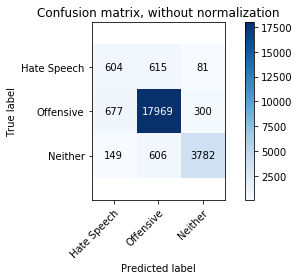

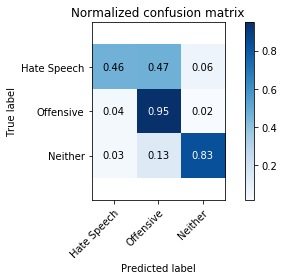

In [17]:
plot_confusion_matrices(preds, labels)